## Data visualization and analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import mne # mne는 MNE-Python이라는 파이썬 기반의 라이브러리이고, 주로 EEG, MEG, fNIRS, ECoG 같은 신경생리학적 뇌파 데이터 분석에 특화된 도구

## Sampling, bias, and summary statistics

Population - entire dataset
Sample - representative subset of the population
Basic statistics
 - typical values of the dataset: mean, median, mode
 - spread of the dataset: variance, standard deviation
--------------------------------------------------------------------------------------
- 모집단: 모든 데이터셋 이용
- 표본: 모집단에서 대표적인 성격을 띄는 서브셋
- 우리가 다루는 샘플은 모집단에서 셀렉션션해서 사용 -> 바이어스가 생길 수 있다.
- 아래 코드에서 랜덤 셀렉션과 일부러 바이어스를 만들어서 셀렉션하는 두가지 방식 확인

Mode of random sample: ModeResult(mode=np.float64(64.30479936043058), count=np.int64(3))
Mode of biased sample: ModeResult(mode=np.float64(32.24374178054928), count=np.int64(1))


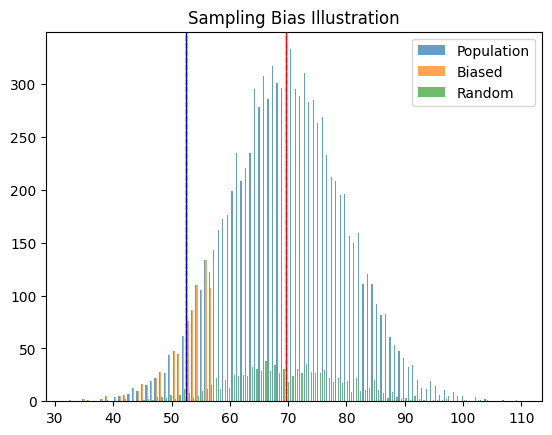

In [ ]:
# 모집단: 평균 70, 표준편차 10인 정규분포로 생성된 10,000개의 값
# Create population data
population = np.random.normal(70, 10, 10000)

# 만개 데이터에서 천개를 골라낼건데, 하나는 일부러 바이어스를 준다.
# Sampling (biased sample vs. random sample)
biased_sample = sorted(population)[:1000] # 맨 앞에서부터 천개를 가져온다. (작은 수부터) / 편향된 샘플: 모딥단의 가장 작은 값 1,000개를 선택 -> 평균보다 훨씬 낮은 값들로만 구성됨 
random_sample = np.random.choice(population, 1000) # 랜덤으로 만개 중 임의로 천개를 가져온다. / 무작위 샘플: 모집단에서 무작위로 1,000개 추출 -> 전체 분포를 어느 정도 잘 대표함

# 세 가지 데이터를 각각 히스토그램으로시각화
# 평균 값을 기준으로 수직선 그림
# Visualize the distributions
plt.hist([population, biased_sample, random_sample], label=['Population', 'Biased', 'Random'], bins=100, alpha=0.7) # bins의 수에 따라 그래프가 다르게 그려진다.
plt.legend(); plt.title("Sampling Bias Illustration")
plt.axvline(np.mean(biased_sample), color='blue', linewidth=1)
plt.axvline(np.mean(biased_sample), color='blue', linestyle='dashed', linewidth=1)

plt.axvline(np.mean(random_sample), color='red', linewidth=1)
plt.axvline(np.mean(random_sample), color='red', linestyle='dashed', linewidth=1)

from scipy import stats
print('Mode of random sample:', stats.mode(random_sample))
print('Mode of biased sample:', stats.mode(biased_sample))

<결과>: "모집단을 대표하지 않는 방식으로 데이터를 수집하면, 그 결과는 현실을 왜곡하며, 잘못된 결론을 유도한다."
- 파란색(Population): 평균 70을 중심으로 좌우대칭인 정규분포
- 주황색(Biased): 왼쪽에 몰려 있고, 평균값이 70보다 훨씬 작음
- 초록색(Random): 전체 Population과 유사한 형태지만 샘플 수가 적기 때문에 약간 들쭉날쭉함
- 파란색 수직선: 편향 샘플의 평균
- 빨간색 수직선: 무작위 샘플의 평균
--------------------------------------------------------------------------------------
- Sampling Bias (표본 편향): 모집단을 제대로 대표하지 못하는 방식으로 표본을 뽑은 것
- 대표성 (Representativeness): 샘플이 모집단의 분포(형태, 평균 등)를 얼마나 잘 반영하느냐
- 평균의 이동: 편향된 샘플은 평균이 모집단 평균보다 낮거나 높게 치우쳐 있음
- 일반화의 한계: 편향된 표본에서 얻은 결론을 전체 모집단에 적용하면 잘못된 결론에 도달할 수 있음
--------------------------------------------------------------------------------------
- 모집단이 정규분포를 따른다고 해도, 샘플링 방식에 따라 결과의 신뢰도와 일반화 가능성이 크게 달라진다.
- 무작위 샘플은 어느 정도 모집단의 특성을 반영하여 재현 가능성(representativeness)이 높지만, 편향된 샘플은 모집단의 평균조차 포함하지 않아 결과를 왜곡하게 된다.
- 따라서 작은 샘플만으로 실험을 수행할 경우, 그 샘플이 모집단을 제대로 대표하는지를 반드시 검토해야 하며, 편향된 샘플은 일반화에 매우 취약하다는 점을 인지해야 한다.
--------------------------------------------------------------------------------------
- Population은 가우시안을 따르고, Random은 가우시안과 비슷하지만 Population과 비교하면 낮다 Biased는 shape도 normal distribution이 아니다.
- Population도 가우시안인데, 원래 같으면 mean을 중심으로 데이터가 골라져야 representativeness distribution이라 할 수 있는데, 상대적으로 Random 셀렉셕 같은 경우, 여러 값 중에서 골라져서 어느정보 비슷한 distribution을 뜬다다.
- 반면 Biase는 데이터의 극히 일부만 표현하고 있다. average 부분은 포함하지 않는다. 그렇기 때문에 적은 샘플로 실험한다고 가정하면, 이 결과를 모든 결과로 일반화하기 어렵다.

Text(0.5, 1.0, 'Sampling Bias Illustration')

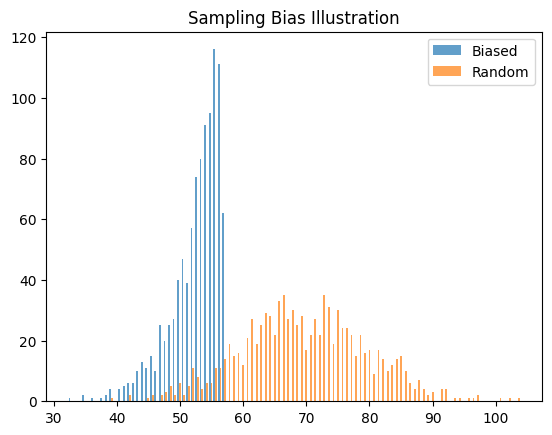

In [4]:
# 위의 결과는 모집단과 함께 본 것이고, 아래 결과는 Biased와 Random에 대해서 살펴보는 것
# Visualize the distributions
plt.hist([biased_sample, random_sample], label=['Biased', 'Random'], bins=100, alpha=0.7)
plt.legend(); plt.title("Sampling Bias Illustration")

## Why visualization matters

In this example, we will see randomly made dataset that show the same statistic values but different data behavior.
Using data exploration through visualization, you can avoid potential mistakes

In [6]:
df_anscombe = pd.read_csv('../data/Anscombe_quartet_data.csv')

df_dataset1 = df_anscombe[['x123', 'y1']].rename(columns={'x123': 'x', 'y1': 'y'})
df_dataset2 = df_anscombe[['x123', 'y2']].rename(columns={'x123': 'x', 'y2': 'y'})
df_dataset3 = df_anscombe[['x123', 'y3']].rename(columns={'x123': 'x', 'y3': 'y'})
df_dataset4 = df_anscombe[['x4', 'y4']].rename(columns={'x4': 'x', 'y4': 'y'})


print(pd.concat([df_dataset1, df_dataset2, df_dataset3, df_dataset4], axis=1))

       x      y     x     y     x      y     x      y
0   10.0   8.04  10.0  9.14  10.0   7.46   8.0   6.58
1    8.0   6.95   8.0  8.14   8.0   6.77   8.0   5.76
2   13.0   7.58  13.0  8.74  13.0  12.74   8.0   7.71
3    9.0   8.81   9.0  8.77   9.0   7.11   8.0   8.84
4   11.0   8.33  11.0  9.26  11.0   7.81   8.0   8.47
5   14.0   9.96  14.0  8.10  14.0   8.84   8.0   7.04
6    6.0   7.24   6.0  6.13   6.0   6.08   8.0   5.25
7    4.0   4.26   4.0  3.10   4.0   5.39  19.0  12.50
8   12.0  10.84  12.0  9.13  12.0   8.15   8.0   5.56
9    7.0   4.82   7.0  7.26   7.0   6.42   8.0   7.91
10   5.0   5.68   5.0  4.74   5.0   5.73   8.0   6.89


In [7]:
print('\nThe sum of x in dataset1 to 4')
for i in [df_dataset1, df_dataset2, df_dataset3, df_dataset4]:
    print(np.sum(i['x'].values))

print('\nThe means of x in dataset1 to 4')
for i in [df_dataset1, df_dataset2, df_dataset3, df_dataset4]:
    print(np.mean(i['x'].values))

print('\nThe standard deviation of x in dataset1 to 4')
for i in [df_dataset1, df_dataset2, df_dataset3, df_dataset4]:
    print(np.std(i['x'].values))


The sum of x in dataset1 to 4
99.0
99.0
99.0
99.0

The means of x in dataset1 to 4
9.0
9.0
9.0
9.0

The standard deviation of x in dataset1 to 4
3.1622776601683795
3.1622776601683795
3.1622776601683795
3.1622776601683795


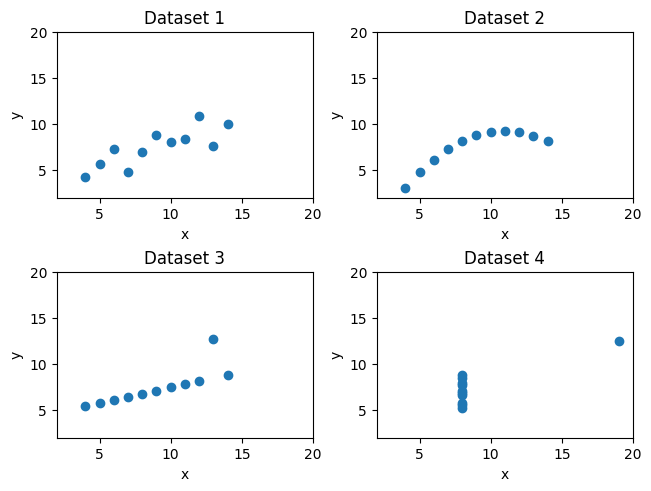

In [8]:
fig, axs = plt.subplots(2,2, layout='constrained')
axs = axs.flatten() # Make 2D to 1D
for idx, val in enumerate([df_dataset1, df_dataset2, df_dataset3, df_dataset4]):
    axs[idx].scatter(val['x'].values, val['y'].values)
    axs[idx].set_xlabel('x')
    axs[idx].set_ylabel('y')
    axs[idx].set_title(f'Dataset {idx+1}')
    axs[idx].set_xlim(2, 20)
    axs[idx].set_ylim(2, 20)

<결과>: "평균, 분산, 표준편차가 같더라도 데이터의 분포는 완전히 다를 수 있다"는 걸 시각적으로 보여줌
- Anscombe의 사중주(Quartet)는 4개의 데이터셋이 동일한 평균, 분산, 상관계수, 회귀선 등을 갖지만, 시각화하면 완전히 다른 분포 형태를 보이는 예시
- 단순히 숫자(통계값)만 봐서는 분포의 형태를 전혀 파악할 수 없음
- 평균, 분산, 상관계수만 가지고 데이터를 판단하면 오판 가능성 큼
- 이상치나 분포 형태는 반드시 그래프를 통해 확인해야 함
- 실제 데이터 분석, 머신러닝 프로젝트에서도 항상 시각화를 병행할 것
-----------------------------------------------------------------------------
- 1. 선형적인 관계가 뚜렷함
- 2. 비선형 곡선 형태 (포물선 느낌)
- 3. 거의 직선이지만 한 개 이상치(outlier)가 있음
- 4. x는 거의 일정하지만 하나의 이상치로 인해 상관계수가 생김
-----------------------------------------------------------------------------
- 시각화의 중요성: 숫자 통계값(mean, std 등)은 분포의 형태를 완전히 설명하지 못함. 항상 시각화로 데이터 확인이 필요
- Outlier 영향: 이상치 한 개가 전체 통계값(평균, 상관계수 등)에 큰 영향을 줄 수 있음
- 데이터 분포의 다양성: 통계값이 동일해도 데이터의 형태는 전혀 다를 수 있음 → 정규성 검정, 시각화 필수
- EDA (Exploratory Data Analysis): 데이터를 이해하고 모델링 전 전처리, 특성 이해를 위한 탐색적 분석의 핵심 사례로 자주 사용됨

## Descriptive statistics + outlier effects
- Mean and median upon an outlier
- Visualization using scatter, boxplot and violin plot

Random dataset with an outlier
Mean: 61.61990345582189 Median: 48.387409999675214
Random dataset without an outlier
Median: 49.912065659031526 Median: 48.482890682102024


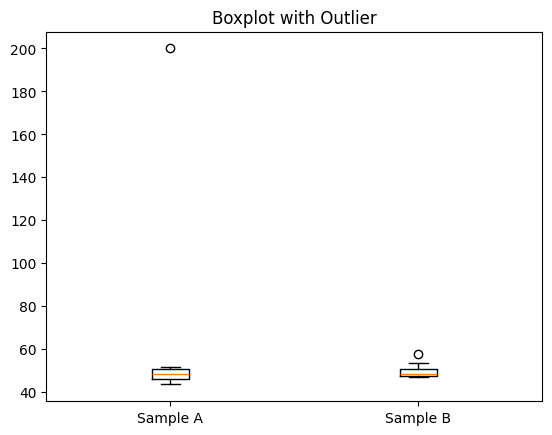

In [ ]:
# 만약 데이터가 10개가 아니고, 1,000개라면 outlier의 영향이 적어진다.
# 10개일 때에는 Mean과 Median의 차이가 컸지만, 1,000개일 때는 그 차이가 작다.
# 50: 평균 / 5: 표준편차 / 10: 생성할 샘플 개수
# Mauual outlier 
sampleA = np.append(np.random.normal(50, 5, 10), [200]) # 200이라는 이상치가 존재
sampleB = np.random.normal(50, 5, 10)

fig, ax = plt.subplots()
ax.boxplot([sampleA, sampleB])
ax.set_xticklabels(['Sample A', 'Sample B'])
ax.set_title("Boxplot with Outlier")

# Mean 값이 outlier에 더 민감하다.
# Mean vs Median 비교
print("Random dataset with an outlier")
print("Mean:", np.mean(sampleA), "Median:", np.median(sampleA))

print("Random dataset without an outlier")
print("Median:", np.mean(sampleB), "Median:", np.median(sampleB))

<Axes: xlabel='sex', ylabel='age'>

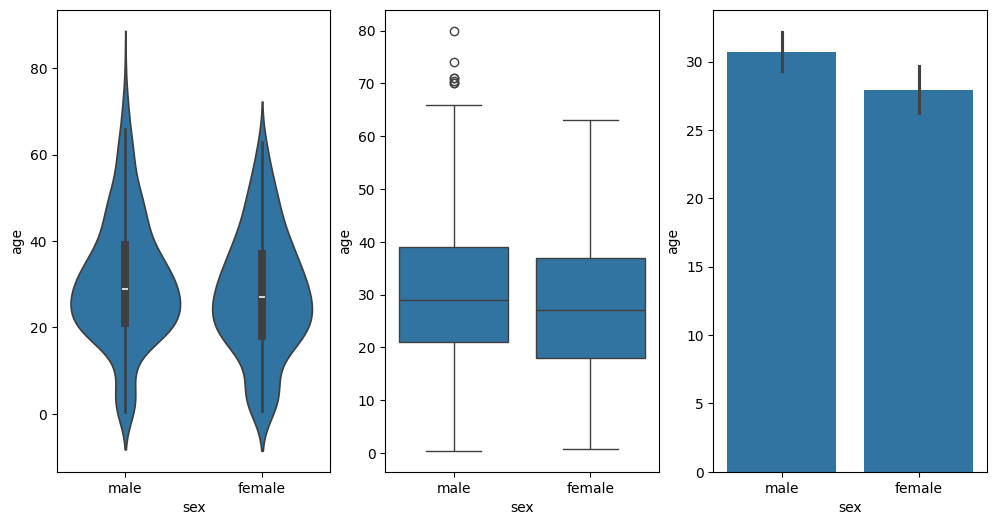

In [ ]:
import seaborn as sns
df = sns.load_dataset("titanic")

fix, ax = plt.subplots(1, 3, figsize=(12, 6))
sns.violinplot(x="sex", y="age", data=df, ax=ax[0])
sns.boxplot(x="sex", y="age", data=df, ax=ax[1])
sns.barplot(x="sex", y="age", data=df, ax=ax[2])

# 시각화하는 방법에 따라 얻을 수 있는 정보량이 다르다.
# 바플롯은 여러 개의 샘플 데이터의 평균을 시각화하면 이는 충분한 데이터를 가지지 않을 수 있다.
# 데이터가 이상치의 영향을 받을 경우, standard error는 커보일 수 있지만, 박스플롯이나 바이올린처럼 range를 알기 어렵다.
# 여러 샘플인 경우는 바이올린 또는 박스가 적합한 시각화 방법일 수 있다.


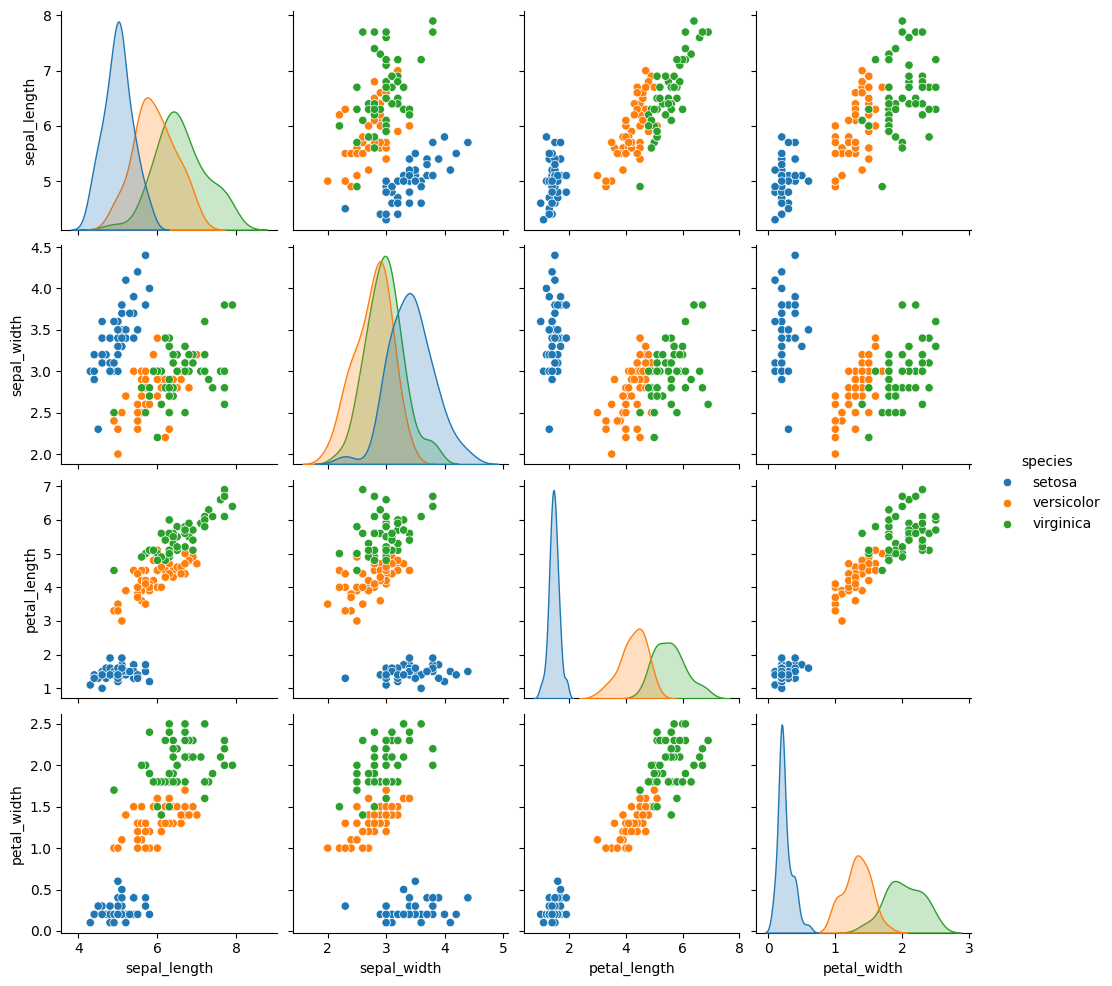

In [14]:
df_iris = sns.load_dataset("iris")
sns.pairplot(df_iris, hue="species")

<Axes: >

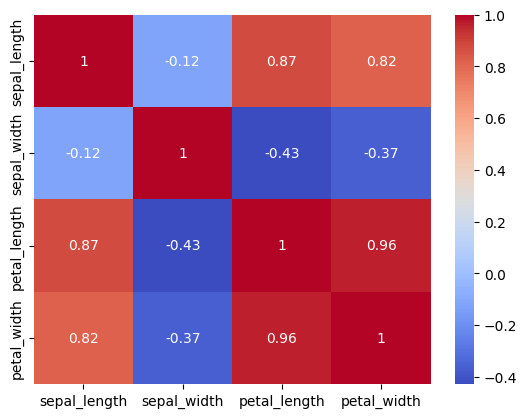

In [11]:
# Heatmap
corr = df_iris.drop('species', axis=1).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

## Dimensionality reduction practice
- PCA
- t-SNE
----------------------------------------------------------------------------
- 데이터셋(8x8 이미지, 64차원)을 차원 축소기법인 PCA와 t-SNE를 이용해 2차원 시각화로 변환하고 비교하는 작업
----------------------------------------------------------------------------
- PCA
    - 고차원 데이터를 저차원으로 축소하면서도 정보(분산)를 최대한 보존하는 방법
    - 직교하는 새로운 축(주성분)을 찾아 데이터를 재표현함
    - 작동 방식
        - 각 feautre의 분산 방향(축)을 찾아 정렬
        - 가장 분산이 큰 방향 -> 첫 번째 주성분(PC1)
        - 그 다음 큰 분산 방향 -> 두 번째 주성분(PC2)
        - 이렇게 차례로 축을 잡고 데이터를 그 축에 투영함
    - 특성
        - 선형(linear) 변환
        - 빠르고 해석 가능
        시각화, 노이즈 제거, 압축 등에 적합합
----------------------------------------------------------------------------
- t-SNE
    - 고차원 데이터의 국소적인 구조(이웃 관계)를 비선형적으로 보존한 채 저차원으로 표현
    - 주로 시각화 목적으로 사용됨
    - 작동 방식
        - 고차원에서 가까운 점끼리 확률적으로 유사도를 계산
        - 저차원에서도 이 유사도를 유지하도록 점들의 위치를 조정
        - KL Divergence를 줄이기 위한 최적화 과정 반복
    - 특성
        - 비선형이며, 고차원 공간의 복잡한 구조를 잘 보존
        - 결과가 반복마다 조금씩 다를 수 있음(비결정적)
        - 해석보다 시각화용에 초점점
----------------------------------------------------------------------------
- n_components=2의 의미
    - 2차원으로 축소
    - 고차원 데이터를 2개의 축(X, Y)에 투영해서 시각화 가능한 형태로 만드는 것
    - 2차원이니까 2D 산점도에 각 점을 찍을 수 있음음

Shape of the original dataset: (1797, 64)


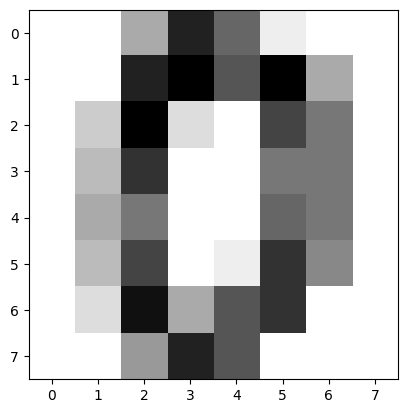

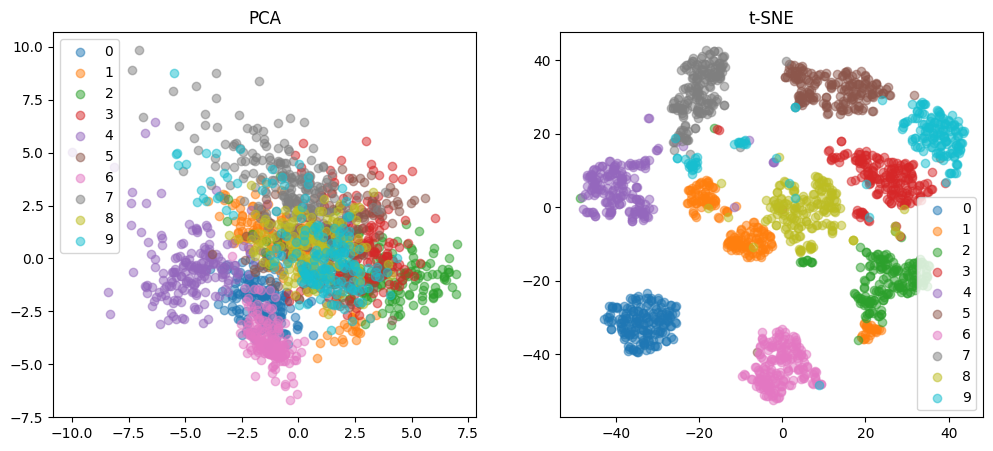

In [ ]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

digits = load_digits()
X = digits.data
y = digits.target

print("Shape of the original dataset:", X.shape)
img = X[0].reshape(8, 8)
fig, ax = plt.subplots()
plt.imshow(img, cmap='binary')
plt.show()


# PCA
X_scaled = StandardScaler().fit_transform(X) # standardize the data z = (x - u) / s
X_pca = PCA(n_components=2).fit_transform(X_scaled)

# t-SNE
X_tsne = TSNE(n_components=2).fit_transform(X_scaled)

# 시각화 비교
fig, axs = plt.subplots(1, 2, figsize=(12,5))
for i in np.unique(y):
    axs[0].scatter(X_pca[y==i,0], X_pca[y==i,1], label=i, alpha=0.5)
    axs[1].scatter(X_tsne[y==i,0], X_tsne[y==i,1], label=i, alpha=0.5)
axs[0].set_title('PCA'); axs[1].set_title('t-SNE'); axs[0].legend(); axs[1].legend()


## Practice using Biosignal - EEG data

Opening raw data file C:\Users\idaeu\mne_data\MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using matplotlib as 2D backend.


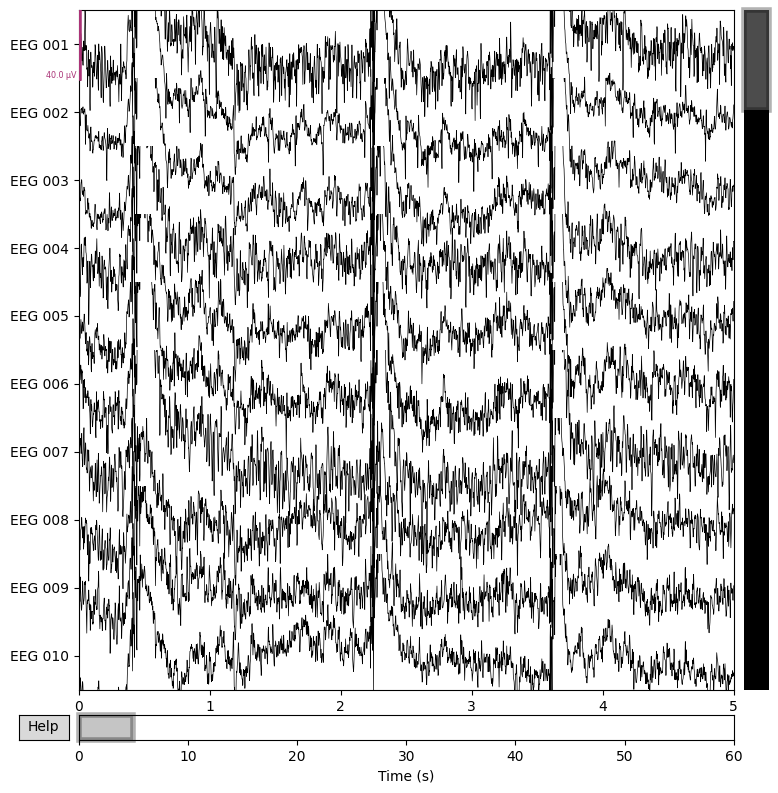

In [ ]:
# MNE-Python 라이브러리를 이용해서 EEG(raw) 데이터를 불러와 시각화하는 과정
# 그림은 실제로 EEG 신호 10개 채널을 시간에 따라 시각화한 스컬프 EEG 플롯(raw plot)

import mne

data_path = mne.datasets.sample.data_path()
raw = mne.io.read_raw_fif(str(data_path) + '/MEG/sample/sample_audvis_raw.fif', preload=True)

raw.pick_types(eeg=True, stim=True)
raw.crop(tmax=60) # 0~60초 구간만 잘라서 사용

disp_raw = raw.plot(n_channels=10, duration=5) # 위에서 선택한 EEG 채널 중 10개만 보여주고, 한 화면에 5초 간격으로 보여줌줌

## Simple preprocessing + feature extraction
- Epoching (data segmentation)
    - 연속된 EEG 데이터(raw)를 특정 이벤트를 기준으로 잘라내는 과정
    - 흔히 자극 제시 전후의 일정 시간 구간을 잘라서 사용
    - 자극에 따른 뇌 반응을 정렬하고 평균 내기 위함
    - 이후 ERP 분석, 머신러닝 분류 등에 사용용
- Divde data based on event labels
    - 자극 종류에 따라 epoch들을 그룹화
    - 즉, 레이블이 있는 자극별로 데이터를 나누는 것
    - 자극 종류별 뇌 반응을 비교하거나 분류할 수 있게 됨
    - 조건(condition)별 ERP 생성이 가능함함
- Visualize event-related potentials (ERPs)
    - 같은 조건의 epoch들을 평균해서 만들어낸 뇌 반응의 대표 신호
    - ERP는 노이즈를 줄이고 공통된 신경 반응을 부각시켜줌
    - 특징
        - 시간 도메인에서 분석: 특정 시간에 어떤 전기적 반응이 있는지
        - 주로 감각 처리, 인지 반응, 주의 전환 등과 관련된 반응을 파악할 때 사용

In [32]:
dir(raw)

['__class__',
 '__contains__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_annotations',
 '_cals',
 '_check_bad_segment',
 '_comp',
 '_cropped_samp',
 '_data',
 '_dtype',
 '_dtype_',
 '_extra_attributes',
 '_filenames',
 '_first_samps',
 '_first_time',
 '_get_buffer_size',
 '_get_channel_positions',
 '_get_duration_string',
 '_getitem',
 '_handle_tmin_tmax',
 '_init_kwargs',
 '_last_samps',
 '_last_time',
 '_orig_units',
 '_parse_get_set_params',
 '_pick_drop_channels',
 '_pick_projs',
 '_preload_data',
 '_projector',
 '_raw_extras',
 '_raw_lengths',
 '_read_comp_grade',
 '_read_picks',
 '_read_

86 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]
Not setting metadata
40 matching events found
Setting baseline interval to [-0.49948803289596966, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 40 events and 902 original time points ...
1 bad epochs dropped
<Epochs | 39 events (all good), -0.499 – 1.001 s (baseline -0.499 – 0 s), ~21.2 MiB, data loaded,
 'Auditory/Left': 20
 'Visual/Left': 19>


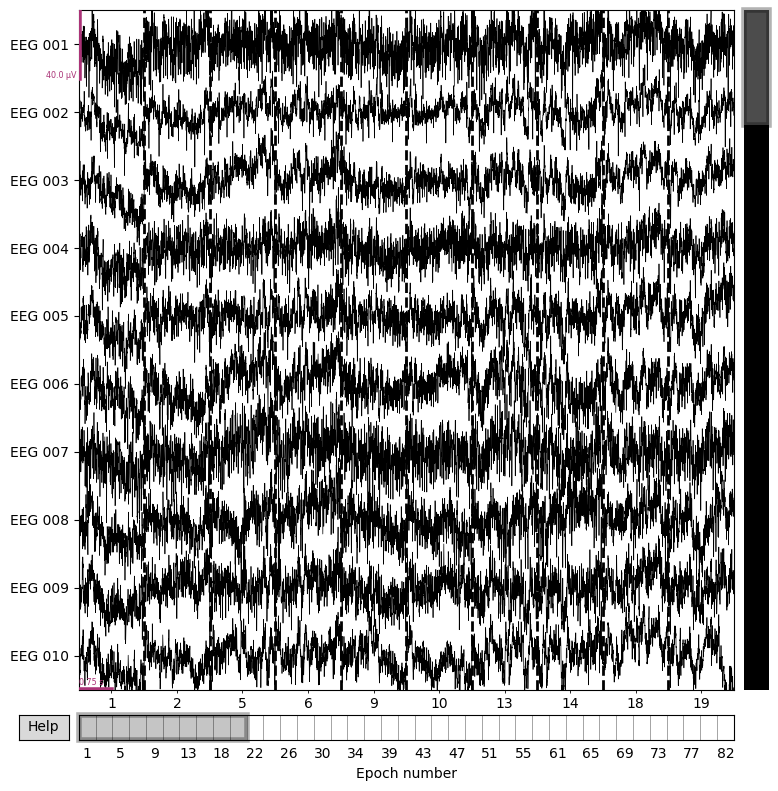

In [ ]:
# EEG 데이터에서 특정 자극(event)을 기준으로 Epoch 분할(세분화)을 하고, 그 epoch들을 시각화하는 전형적인 ERP 분석 처리 과정

# STI 014 채널에서 자극 발생 시점들을 찾음(총 86개의 자극이 있었고, 자극 ID는 6종류 있음 / 여기서는 1과 3만 선택할 것)
events = mne.find_events(raw, stim_channel='STI 014')
event_id = {'Auditory/Left': 1, 'Visual/Left': 3} # 관심 있는 자극 2개만 선택(1: 왼쪽 소리 자극, 3: 왼쪽 시각 자극)

# 자극 발생 시점을 기준으로 -0.5초부터 +1.0초까지 잘라냄(1.5초 길이의 epoch)
# 자극 전 구간(-0.5초 ~ 0초) 평균을 뺴서 baseline correction 수행
# 총 40개의 이벤트(epoch)를 만들 수 있었고, 1개는 artifact 등으로 제거되어 최종적으로 39개만 유지
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=-0.5, tmax=1.0, baseline=(None, 0), preload=True)

print(epochs)
disp_epochs = epochs.plot(n_epochs=10, n_channels=10) # EEG 10채널을 사용해 한 번에 10개의 epoch 시각화

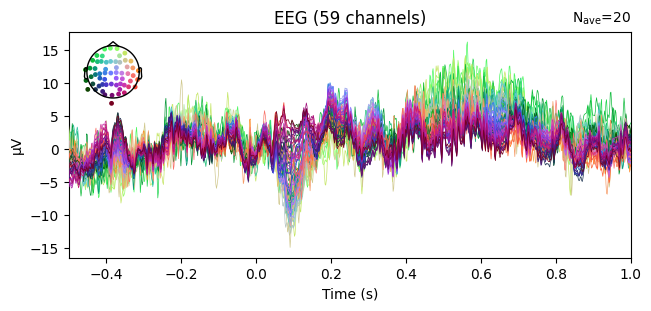

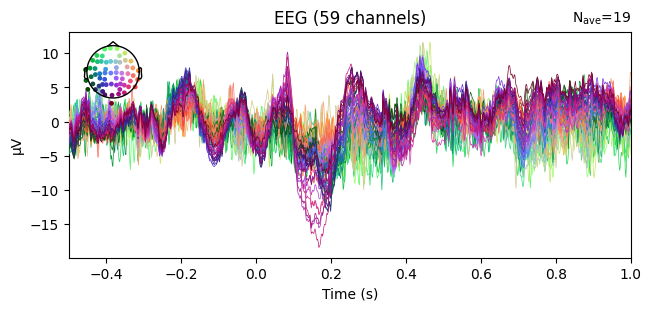

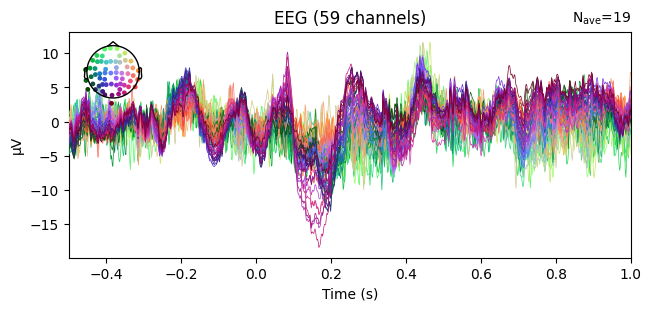

In [ ]:
# ERP(자극에 대한 평균 EEG 반응)를 시각화한 결과

# 특정 조건의 epoch만 선택
# 청각/시각 자극
evoked_aud = epochs['Auditory/Left'].average()
evoked_vis = epochs['Visual/Left'].average()

# 채널별 신호는 색깔로 구분되어 있고, 좌측 상단은 채널 위치(topomap)를 의미미
# If you encounter an error, use the lateset version of matplotlib 
evoked_aud.plot() # Auditory/Left 자극 조건, 평균한 결과가 상대적으로 부드럽고, 특정 시간대에 뇌 반응 파형이 나타남
evoked_vis.plot() # Visual/Left 자극 조건, 자극 후 0.2초 부근에서 강한 음전위(음의 피크)가 여러 채널에서 동시에 나타남, 시각 자극 ERP는 일반적으로 시각 피질의 특성적인 반응 패턴을 보임

- ERP란: 자극 이후의 평균 뇌파 반응으로, 잡음을 줄이고 신호만 남긴 형태
- 왜 평균?: EEG는 노이즈가 많기 떄문에 자극마다 평균하여 일관된 신경 반응만 추출
- 사용 용도: 인지 반응 분석, 자극에 따른 대뇌 활동 구분, 뇌 질환 연구 등
- 시각적 포인트: 자극 이후 특정 시간에서 뇌 반응이 강하게 나타나는가?, 채널별 분포는?
----------------------------------------------------------------------------------

- 차원 축소(PCA)한 뒤, 자극 종류(event ID)에 따라 시각적으로 구분되는지 확인하는 분석
- 그림은 각 epoch을 2차원 공간에 투영한 PCA 시각화 결과

<그래프 해석>
- X축: PC1, Y축: PC2
- 색깔로 그룹이 나뉘어 보이면 → 자극에 따라 뇌 반응이 구분됨
- 아래 그림에서 약간의 구분은 있지만, 완전히 분리되진 않음 → PCA만으로는 완벽한 분류는 어려움

Shape of the scaled data: (39, 61336)


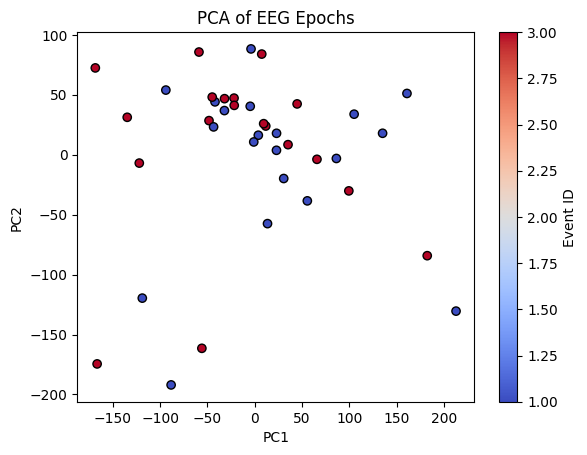

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 평균을 뺀 후 epochs 데이터 → (n_epochs, n_channels × n_times)
X = epochs.get_data()  # shape: (n_trials, n_channels, n_times)
X_flat = X.reshape(X.shape[0], -1)  # Flatten: 각 trial을 하나의 벡터로

# 표준화 + PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

print('Shape of the scaled data:', X_scaled.shape)

pca = PCA(n_components=2) # PCA로 데이터를 2차원으로 축소
X_pca = pca.fit_transform(X_scaled)

# 시각화
import matplotlib.pyplot as plt
labels = epochs.events[:, 2]
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='coolwarm', edgecolor='k')
plt.title("PCA of EEG Epochs")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.colorbar(label='Event ID')

- EEG epoch 데이터를 차원 축소한 후 t-SNE를 사용해서 시각화
- EEG epoch 데이터를 2차원으로 축소해서 자극 조건(Event ID)에 따라 군집화되는지 시각적으로 확인하는 것
- t-SNE는 특히 고차원 데이터의 군집 구조(클러스터링)를 시각적으로 파악할 때 강력한 도구

<그래프 해석>
- 각 점 = 1개의 EEG epoch
- 색깔 = 자극 종류 (Event ID)
- 비슷한 자극을 받은 epoch들이 비슷한 위치에 모여 있으면 군집화 성공
- 이번 결과에서는 PCA보다는 좀 더 조밀한 모임이 생겼지만, 완전히 명확하게 분리된 건 아님

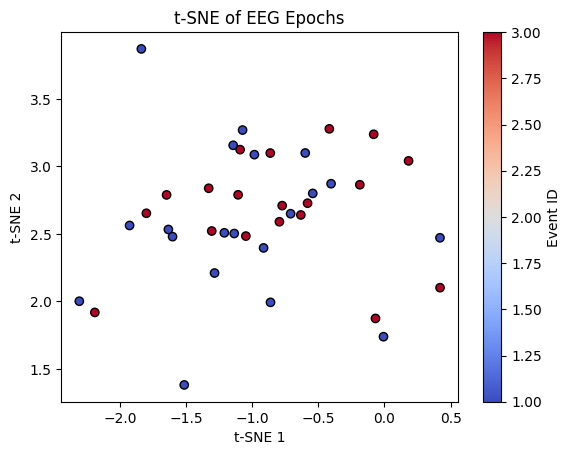

In [36]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels, cmap='coolwarm', edgecolor='k')
plt.title("t-SNE of EEG Epochs")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.colorbar(label='Event ID')

In [18]:
df = pd.read_csv('../data/train.csv')
print('The number of rows in the dataset:', df.shape[0])
print(df.head(10))

The number of rows in the dataset: 42000
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   
5      0       0       0       0       0       0       0       0       0   
6      7       0       0       0       0       0       0       0       0   
7      3       0       0       0       0       0       0       0       0   
8      5       0       0       0       0       0       0       0       0   
9      3       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0

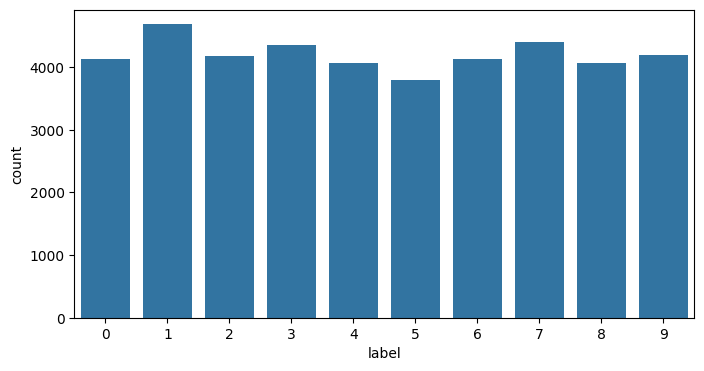

In [19]:
plt.figure(figsize=(8,4)) # The data is balanced, so we can use accuracy_score metrics for our cross validation
sns.countplot(x='label', data=df)
plt.show()

In [20]:
pixel_values = df.drop(columns=['label'])
targets = df['label']

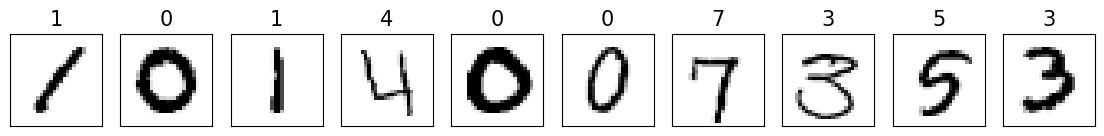

In [21]:
plt.figure(figsize=(14,12))
for i, (pixel, target) in enumerate(zip(pixel_values.values[:10], targets[:10])):
    plt.subplot(1, 10, i+1)
    img = pixel.reshape(28,28) # 위에서는 8x8이라면, 여기서는 28x28
    plt.imshow(img, cmap='binary')
    plt.title(target, fontdict={'fontsize':15})
    plt.xticks([])
    plt.yticks([])

In [22]:
tsne = TSNE(n_components=2, random_state=42, n_jobs=6)   # reducing the n_columns to 2
# for n_jobs, choose appropriate number based on your CPU cores
transformed_data = tsne.fit_transform(pixel_values.iloc[:10000, :])

In [23]:
tsne_df = pd.DataFrame(np.column_stack((transformed_data, targets[:10000])),
                        columns=["X", "y", "targets"])
tsne_df.head(10) # Here we see there are only 2 columns in the transformed dataset

,X,y,targets
0,-67.859726,-34.281727,1.0
1,78.355042,-8.809983,0.0
2,-36.390587,-9.932150,1.0
3,11.457018,75.724060,4.0
4,84.096626,-22.399708,0.0
5,60.529228,-8.231209,0.0
6,-45.583904,42.210602,7.0
7,27.416954,-23.232458,3.0
8,24.546316,-0.177952,5.0
9,25.963886,-57.212868,3.0


Text(0.5, 1.0, 'CLustered data after t-SNE transformation')

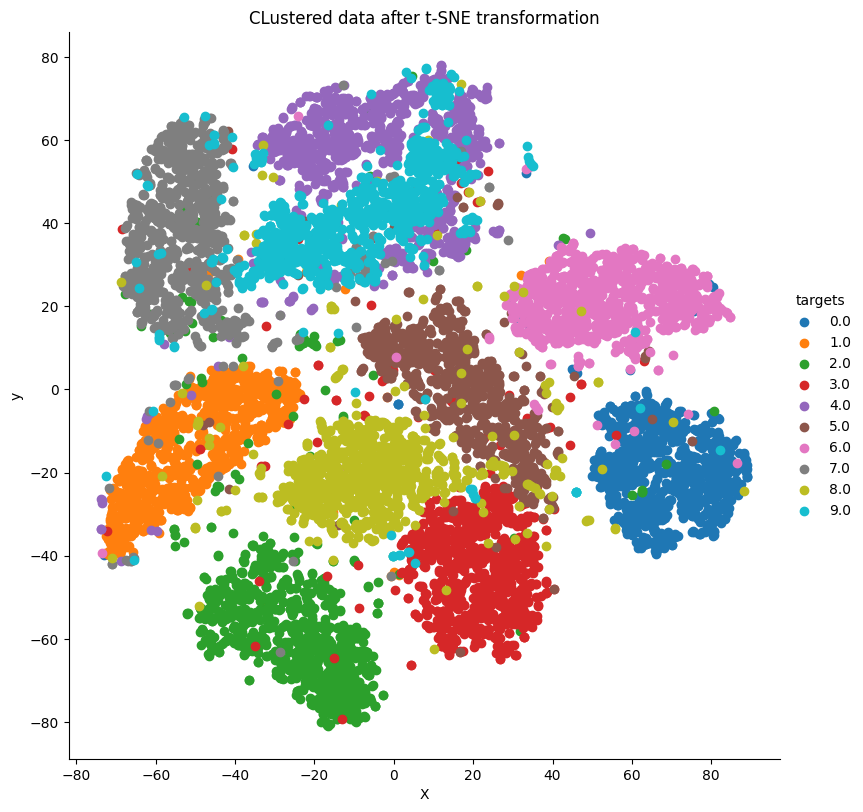

In [24]:
grid = sns.FacetGrid(tsne_df, hue="targets", height=8)
grid.map(plt.scatter, "X", "y").add_legend()
plt.title("CLustered data after t-SNE transformation")

In [25]:
X = df.drop('label', axis=1)
y = df['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=20)  #Splitting into training and validation set

rfc = RandomForestClassifier(n_estimators=6)

rfc.fit(X_train, y_train)

pred = rfc.predict(X_val)
print(f'The accuracy on validation set is {accuracy_score(y_val, pred)}')

The accuracy on validation set is 0.9199047619047619


In [26]:
X = tsne_df.drop('targets', axis=1)
y = tsne_df['targets']

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=20)  #Splitting into training and validation set

In [27]:
rfc = RandomForestClassifier(n_estimators=6)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=6)

In [28]:
pred = rfc.predict(X_val)
print(f'The accuracy on validation set is {accuracy_score(y_val, pred)}')

The accuracy on validation set is 0.9436


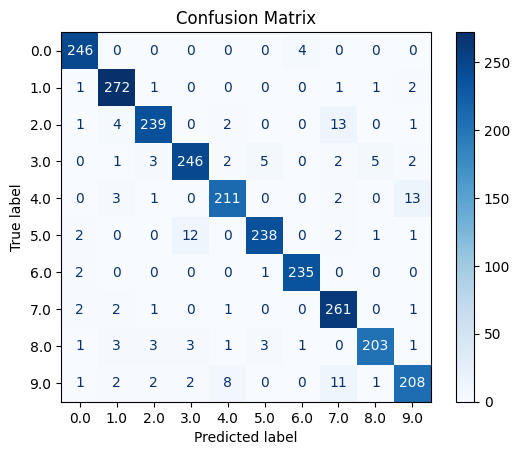

In [29]:
cm = confusion_matrix(y_val, pred)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
disp_cm.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [30]:
scores = cross_val_score(rfc, X, y, cv=5, verbose=1, n_jobs=-1)
print(f'The validation scores are {scores}')
print(f'The mean validation score is {scores.mean()}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


The validation scores are [0.941  0.9495 0.943  0.9365 0.9515]
The mean validation score is 0.9442999999999999


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.9s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.9s finished
